In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure import plotter
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

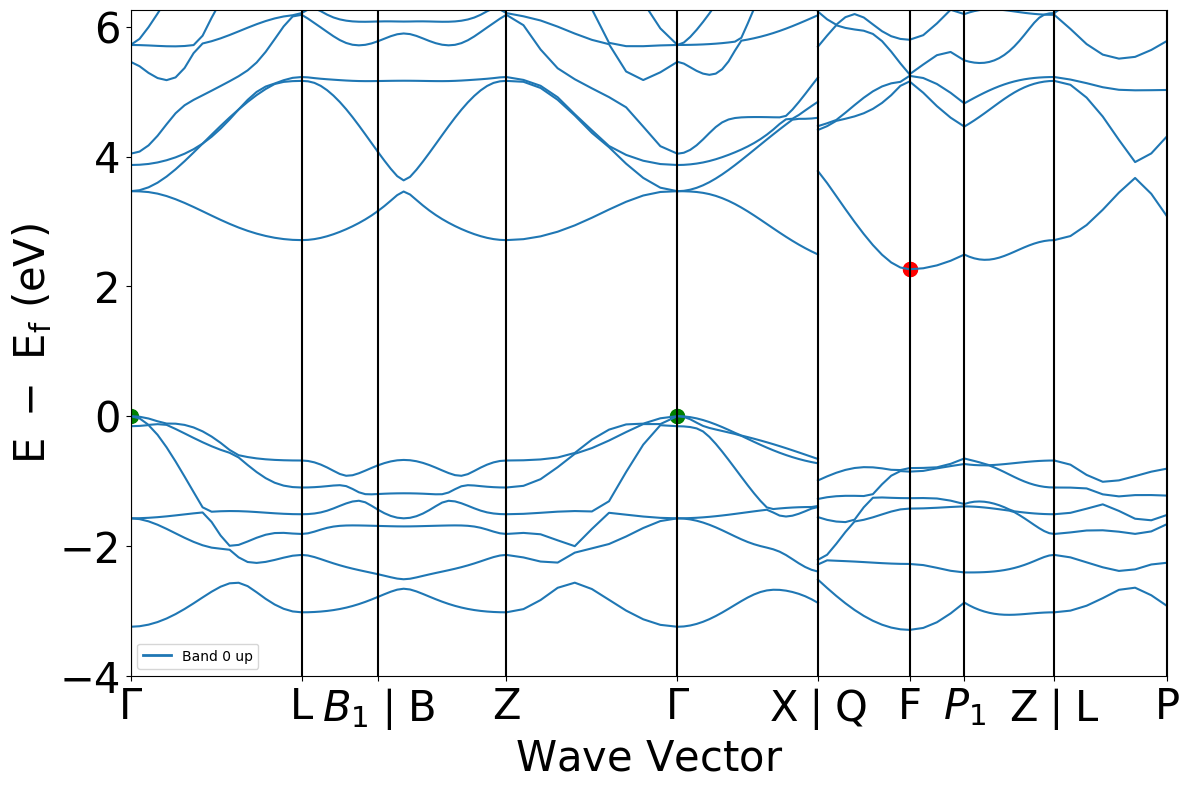

In [26]:
with MPRester("kMkuaNd0F7org0EE2QryQaonTKfVvGw4") as m:
    band_structure = m.get_bandstructure_by_material_id("mp-10226")
plot = BSPlotter(band_structure)
plot.get_plot(vbm_cbm_marker=True)
electro_band_plot = BSPlotter(band_structure)

# Bande interdite

In [27]:
band_gap = band_structure.get_band_gap()
direct = "direct"
if(band_gap['direct'] == False):
    direct = "indirect"
print("La bande d'énergie est "+direct+", vaut "+str(band_gap['energy'])+" eV la de direction de vecteur k est "+str(band_gap['transition'])+" pour la transition.")


La bande d'énergie est indirect, vaut 2.2634999999999996 eV la de direction de vecteur k est \Gamma-F pour la transition.


In [28]:
cbmlist = []
vbmlist = []
cbm = band_structure.get_cbm() #bandes de conduction max
vbm = band_structure.get_vbm() #bandes de valence max
cbm_band_index = cbm["band_index"].items()
vbm_band_index = vbm["band_index"].items()
for cursor in cbm_band_index:
    cbmlist.append(cursor[1][0])
for cursor in vbm_band_index:
    vbmlist.append(cursor[1][0])


vbm = vbmlist[-1]
cbm = cbmlist[0]
print("La dernière bande de valence est la bande "+str(vbm)+".")
print("La dernière bande de conduction est la bande "+str(cbm)+".")

La dernière bande de valence est la bande 13.
La dernière bande de conduction est la bande 15.


# Dispersion

In [29]:
def dEdK(E,k): #pente
    dEdK = (abs((E[-1]-E[0])))/(k[-1]-k[0])
    result = [E[-1],E[0],k[-1],k[0],dEdK]
    return(np.array(result))

data = electro_band_plot.bs_plot_data()
distance = data.get('ticks').get('distance')
distances = data.get('distances') #directions que peut prendre k
energy = data.get('energy') #energie des différentes directions

pente_val = np.zeros((len(distances),5))
pente_cond = np.zeros((len(distances),5))
for i in range(len(distances)): #calcul des pentes associées aux différents vecteurs k
    pente_val[i] = dEdK(energy["1"][i][vbm],distances[i])
    pente_cond[i] = dEdK(energy["1"][i][cbm],distances[i])

finder_for_val = np.zeros(len(distances))
finder_for_cond = np.zeros(len(distances))

for j in range(len(distances)): #détermination de la pente la plus élevée
    finder_for_val[j] = pente_val[j][4]
    finder_for_cond[j] = pente_cond[j][4]

max_val = np.argmax(finder_for_val)
min_val = np.argmin(finder_for_val)
max_cond = np.argmax(finder_for_cond)
min_cond = np.argmin(finder_for_cond)

La pente (dispersion) maximale est en rouge pour la bande de valence et vaut 1.1891137824790936.
La pente (dispersion) maximale est en vert pour la bande de conduction et vaut 3.054644753051579.
La pente (dispersion) minimale est en orange pour la bande de valence et vaut 0.14484735637366916.
La pente (dispersion) minimale est en bleu pour la bande de conduction et vaut 0.4585733259620332.


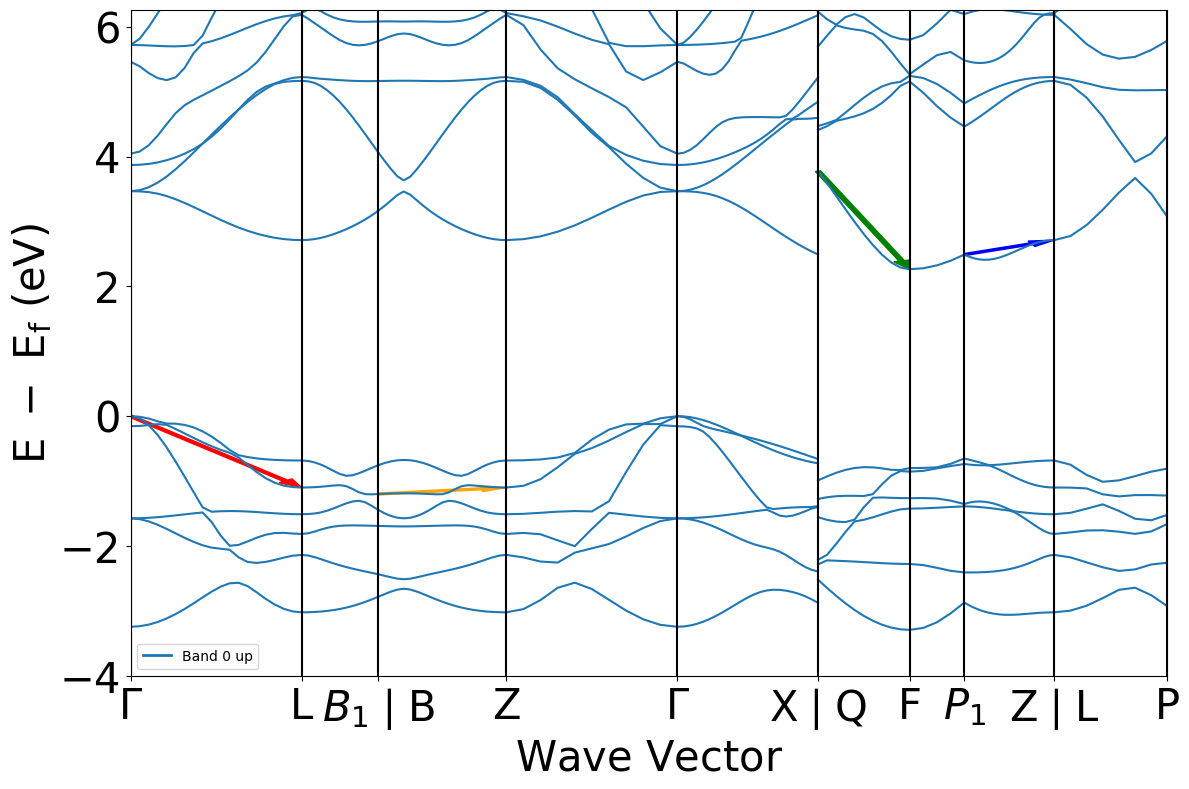

In [30]:
electro_band_plot.get_plot()

pente_val_max = pente_val[max_val] #pente max bande de valence
pente_val_min = pente_val[min_val]#la pente min bande de valence

#plot de la pente max en rouge
plt.arrow(pente_val_max[3],pente_val_max[1],pente_val_max[2]-pente_val_max[3],pente_val_max[0]-pente_val_max[1], color='red',width = 0.03,length_includes_head =True)
#plot de la pente min en orange
plt.arrow(pente_val_min[3],pente_val_min[1],pente_val_min[2]-pente_val_min[3],pente_val_min[0]-pente_val_min[1], color='orange',width = 0.03,length_includes_head =True)

pente_cond_max = pente_cond[max_cond] #pente max bande de conduction
pente_cond_min = pente_cond[min_cond]#pente min bande de conduction

#plot de la pente max en vert
plt.arrow(pente_cond_max[3],pente_cond_max[1],pente_cond_max[2]-pente_cond_max[3],pente_cond_max[0]-pente_cond_max[1], color='green',width = 0.03,length_includes_head = True)
#plot de la pente min en bleu
plt.arrow(pente_cond_min[3],pente_cond_min[1],pente_cond_min[2]-pente_cond_min[3],pente_cond_min[0]-pente_cond_min[1], color='blue',width = 0.03,length_includes_head = True)


print("La pente (dispersion) maximale est en rouge pour la bande de valence et vaut "+str(pente_val_max[4])+".")
print("La pente (dispersion) maximale est en vert pour la bande de conduction et vaut "+str(pente_cond_max[4])+".")
print("La pente (dispersion) minimale est en orange pour la bande de valence et vaut "+str(pente_val_min[4])+".")
print("La pente (dispersion) minimale est en bleu pour la bande de conduction et vaut "+str(pente_cond_min[4])+".")

# Masse effective

In [32]:
hbar = (6.62607015*10**(-34))/(2*np.pi) #[J]
eV = 1.602176634*10**(-19) #[J]
hbar_eV = hbar/eV #[eV]

#interpolation pour VBM
vbms = data.get('vbm')
kval = np.zeros(3)
kval[1] = vbms[0][0]
kval[0] = distances[4][-2]
kval[2] = distances[5][1]

Eval = np.zeros(3)
Eval[1] = vbms[0][1]
Eval[0] = energy.get('1')[4][11][-2]
Eval[2] = energy.get('1')[5][11][1]

interpolation_val = np.polyfit(kval,Eval,2) #interpolation avec 3 énergies
m_eff_val = (vbms[0][0])**2*(hbar_eV**2/(2*interpolation_val[0]))# isolement pour le calcul de la masse effective
print("Masse effective au sommet de la dernière bande de valence = "+str(m_eff_val)+" kg.")

#interpolation pour CBM
cbms = data.get('cbm')

kcond = np.zeros(3)
kcond[1] = cbms[0][0]
kcond[0] = distances[0][-2]
kcond[2] = distances[2][1]

Econd = np.zeros(3)
Econd[1] = vbms[0][1]
Econd[0] = energy.get('1')[0][13][-2]
Econd[2] = energy.get('1')[2][13][1]

interpolation_cond = np.polyfit(kcond,Econd,2) #interpolation avec 3 énergies
m_eff_cond = (cbms[0][0])**2*(hbar_eV**2/(2*interpolation_cond[0])) # isolement pour le calcul de la masse effective
print("Masse effective à la base de la première bande de conduction = "+str(m_eff_cond)+" kg.")

Masse effective au sommet de la dernière bande de valence = -0.0 kg.
Masse effective à la base de la première bande de conduction = 2.0412023143429898e-29 kg.
